In [1]:


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:


import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('../datasets/riemann_pairs_2.csv')

# y = df[['I1_node_n_plus_1[j]', 'I2_node_n_plus_1[j]']]
y = df[['h_true', 'hu_true', 'dt']]

X = df.drop(columns=['h_true', 'hu_true', 'dt'])
# X = df.drop(columns=['I1_node_n_plus_1[j]', 'I2_node_n_plus_1[j]', 'I1_node_true', 'I2_node_true'])

In [4]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
y['h_true']

0        0.909388
1        1.024694
2       -0.295870
3       -0.918737
4       -0.332047
           ...   
25595    1.617763
25596   -1.295755
25597   -0.045593
25598   -0.340861
25599   -0.936638
Name: h_true, Length: 25600, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x700e752cccd0>,
 'caps': [<matplotlib.lines.Line2D at 0x700e752cdd80>,
 'boxes': [<matplotlib.lines.Line2D at 0x700e752ccd90>],
 'medians': [<matplotlib.lines.Line2D at 0x700e752cef20>],
 'fliers': [<matplotlib.lines.Line2D at 0x700e752cc550>],
 'means': []}

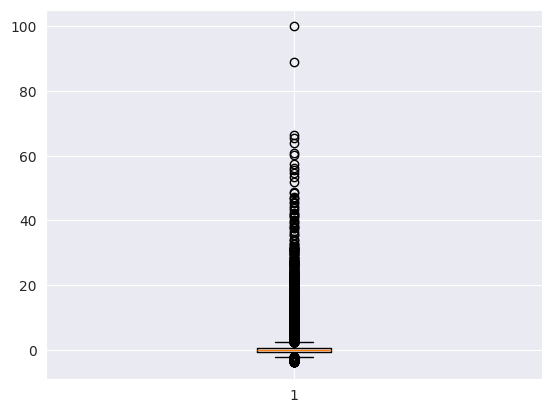

In [6]:
plt.boxplot(y['h_true'])

In [7]:
# Convert pandas DataFrames to PyTorch tensors
train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
val_X_tensor = torch.tensor(val_X.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
val_dataset = TensorDataset(val_X_tensor, val_y_tensor)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 20480
Validation dataset size: 5120


In [7]:
train_dataset[3]

(tensor([-0.1950,  7.9001,  7.4154, -4.0770, -3.3893, -1.4706,  0.4331,  7.5819,
         -3.7297, -3.1061,  0.1429,  7.3768, -3.8845, -3.2644,  7.9001,  7.4154,
          3.7536, -3.3893, -1.4706, -2.3406,  7.5819,  5.5416, -3.1061, -2.0263,
          7.3768,  5.0811, -3.2644, -2.2207]),
 tensor([-1.0760, -3.3871,  0.0038]))

In [8]:
# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training DataLoader batches: {len(train_loader)}")
print(f"Validation DataLoader batches: {len(val_loader)}")

Training DataLoader batches: 320
Validation DataLoader batches: 80


In [29]:
class MLP(nn.Module):
    def __init__(self, input_features=4, hidden_dim=20):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_features, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, hidden_dim)
        # self.layer5 = nn.Linear(hidden_dim, 2)
        self.layer5 = nn.Linear(hidden_dim, 2 * input_features)
        self.activation = elu
        # self.bn = nn.BatchNorm1d(4)

    def forward(self, x):
        # if x.dim() == 1:
        #     x = x.unsqueeze(1)
        # x = self.bn(x)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.layer5(x)
        return x

# Example usage
input_features = 14  # Specify the number of input features
model = MLP(input_features)

print(model)


MLP(
  (layer1): Linear(in_features=14, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=14, bias=True)
)


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
class MSE_Loss_Scaled(torch.nn.Module):
    """
    Mean-squared error loss with custom scaling factors
    for each label component.
    """

    def __init__(self):
        super().__init__()
        # self.register_buffer("scaling_factors", torch.tensor(scaling_factors))

    def forward(self, input, target, scale):
        mse = torch.mean((input - target) ** 2, dim=0)
        mse = torch.dot(scale, mse)
        return mse

In [12]:
class MSE_Loss_Scaled(torch.nn.Module):
    """
    Mean-squared error loss with custom scaling factors
    for each label component.
    """
    def __init__(self, scaling_factors): # Pass factors during initialization
        super().__init__()
        # Register as a buffer so it moves with the model to device
        # and is saved/loaded with the model's state_dict.
        self.register_buffer("scaling_factors", torch.tensor(scaling_factors, dtype=torch.float32))

    def forward(self, input, target): # No 'scale' argument needed here
        mse_per_output = torch.mean((input - target) ** 2, dim=0)
        # Apply the pre-defined scaling factors
        # print(self.scaling_factors.device, mse_per_output.device)
        weighted_mse = self.scaling_factors * mse_per_output
        return weighted_mse.sum() # Sum up the weighted MSEs

In [13]:
train_y_tensor_std = train_y_tensor[:, :2].std(dim=0)
my_scaling_factors = 1.0 / (train_y_tensor_std ** 2)

In [14]:
my_scaling_factors

tensor([0.0915, 0.0001])

In [15]:
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import trange

In [30]:
def F_m( H, u):
    """Mass flux function F_m = Hu."""
    return H * u

def F_h(H, u):
    """Momentum flux function F_h = Hu^2 + g/2 H^2."""
    g = 9.806
    return H * u ** 2 + 0.5 * g * H ** 2


def _step3(data_A, data_B, dt):
    dx = 0.1
    g = 9.806

    I1_node_n_plus_1_A = data_A[:, 0]
    I2_node_n_plus_1_A = data_A[:, 1]

    I1_node_n_plus_1_B = data_B[:, 0]
    I2_node_n_plus_1_B = data_B[:, 1]

    h_node_n_plus_1_char_A = ((I1_node_n_plus_1_A - I2_node_n_plus_1_A) / 2) ** 2 / g
    u_node_n_plus_1_char_A = (I1_node_n_plus_1_A + I2_node_n_plus_1_A) / 2

    h_node_n_plus_1_char_B = ((I1_node_n_plus_1_B - I2_node_n_plus_1_B) / 2) ** 2 / g
    u_node_n_plus_1_char_B = (I1_node_n_plus_1_B + I2_node_n_plus_1_B) / 2


    # h_node_n_plus_1_char_A = data_A[:, 0]
    # hu_node_n_plus_1_char_A = data_A[:, 1]
    #
    # h_node_n_plus_1_char_B = data_B[:, 0]
    # hu_node_n_plus_1_char_B = data_B[:, 1]



    # Calculate u_node at n+1 from the provisional nodal values.
    # Add a small epsilon to avoid division by zero if H is zero.
    # u_node_n_plus_1_char_A = hu_node_n_plus_1_char_A / (h_node_n_plus_1_char_A + 1e-12)
    # u_node_n_plus_1_char_B = hu_node_n_plus_1_char_B / (h_node_n_plus_1_char_B + 1e-12)

    # Fluxes at nodes i and i+1 using the provisional nodal values at n+1.
    flux_m_plus_1_A = F_m(h_node_n_plus_1_char_A, u_node_n_plus_1_char_A)
    flux_m_plus_1_B = F_m(h_node_n_plus_1_char_B, u_node_n_plus_1_char_B)

    flux_h_plus_1_A = F_h(h_node_n_plus_1_char_A, u_node_n_plus_1_char_A)
    flux_h_plus_1_B = F_h(h_node_n_plus_1_char_B, u_node_n_plus_1_char_B)

    # Apply implicit update for conservative variables (based on Eq. 4 with b=0).
    return (
        0.5 * dt / dx * (flux_m_plus_1_B - flux_m_plus_1_A),
        0.5 * dt / dx * (flux_h_plus_1_B - flux_h_plus_1_A)
    )

def _project_I1I2(model, feats):
    # feats: [B, F] -> returns [B, 1]
    w_out = model(feats)                     # [B, 1F]
    w = w_out.view(w_out.size(0), 1, -1)     # [B, 1, F]
    w = torch.softmax(w, dim=-1)             # softmax over features
    return torch.einsum('bij,bj->bi', w, feats)  # [B, 2]

In [31]:
def train_model(model, train_dataloader, val_dataloader, num_epochs=10, learning_rate=0.001):
    # criterion = nn.MSELoss()
    criterion = MSE_Loss_Scaled(my_scaling_factors.tolist()).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    writer = SummaryWriter()

    train_losses = []
    val_losses = []

    pbar = trange(num_epochs)

    for epoch in pbar:
        running_loss = 0.0
        model.train()
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()

            # print(inputs.shape, targets.shape)

            a_feats = inputs[:, :input_features]
            b_feats = inputs[:, input_features:]

            # print(a_feats.shape, b_feats.shape)

            a_out = _project_I1I2(model, a_feats.to(device))
            b_out = _project_I1I2(model, b_feats.to(device))


            # print(a_out.shape, b_out.shape)
            dt = targets[:, 2].to(device)

            dh_preds, dhu_preds = _step3(data_A=a_out, data_B=b_out, dt=dt)

            # print(dh_preds.shape, dhu_preds.shape)

            target_delta = targets[:, :2]

            preds = torch.stack([dh_preds, dhu_preds], dim=1)

            # print(preds.shape, target_delta.shape)

            loss = criterion(preds, target_delta.to(device))

            # return

            # loss = criterion(outputs, targets.to(device), 1. / targets.std(dim=0).to(device))
            # loss = criterion(outputs, targets.to(device))
            # print(loss.shape, loss, targets.std(dim=0).shape)
            # loss /= targets.std(dim=0)
            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_train_loss)

        running_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_dataloader:

                # print(inputs.shape, targets.shape)

                a_feats = inputs[:, :input_features]
                b_feats = inputs[:, input_features:]

                # print(a_feats.shape, b_feats.shape)


                # a_out = model(a_feats.to(device))
                # b_out = model(b_feats.to(device))

                a_out = _project_I1I2(model, a_feats.to(device))
                b_out = _project_I1I2(model, b_feats.to(device))

                # print(a_out.shape, b_out.shape)
                dt = targets[:, 2].to(device)

                dh_preds, dhu_preds = _step3(data_A=a_out, data_B=b_out, dt=dt)

                # print(dh_preds.shape, dhu_preds.shape)

                target_delta = targets[:, :2]

                preds = torch.stack([dh_preds, dhu_preds], dim=1)

                # print(preds.shape, target_delta.shape)

                loss = criterion(preds, target_delta.to(device))

                running_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_loss / len(val_dataloader.dataset)
        val_losses.append(epoch_val_loss)

        if val_losses[-1] <= min(val_losses):
            print('Saving model ...')
            torch.save(model.state_dict(), '../checkpoints/model_pairs_6.pt')


        # Log losses to TensorBoard
        writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
        writer.add_scalar('Loss/Validation', epoch_val_loss, epoch)

        if ((epoch + 1) % 10) == 0:
            # tqdm.write(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
            pbar.set_description(desc=f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

In [32]:
model = MLP(input_features=input_features, hidden_dim=40)
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.LBFGS(model.parameters())
train_model(model.to(device), train_loader, val_loader, num_epochs=800)

  0%|          | 0/800 [00:00<?, ?it/s]

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [77]:
torch.save(model.state_dict(), '../checkpoints/model_pairs_1.pt')

In [139]:
from training.models import load_nn

model = load_nn(path='../checkpoints/model_new_1.pt', input_features=input_features, n_feats=20)

In [129]:
model.eval()

MLP(
  (layer1): Linear(in_features=14, out_features=40, bias=True)
  (layer2): Linear(in_features=40, out_features=40, bias=True)
  (layer3): Linear(in_features=40, out_features=40, bias=True)
  (layer4): Linear(in_features=40, out_features=40, bias=True)
  (layer5): Linear(in_features=40, out_features=2, bias=True)
)

In [140]:
inputs = train_dataset[0]
# inputs = torch.tensor([[5, 0, 5, 0], [2, 1, 2, 1]], dtype=torch.float32)
inputs

(tensor([ 8.7139,  1.7019,  5.3457, -1.4378, -2.8163, -1.9223,  8.4930,  3.2553,
         -1.5061, -2.0472,  8.6047,  3.5577, -1.4710, -1.9074,  1.7019,  5.3457,
          7.8997, -2.8163, -1.9223, -1.6991,  3.2553,  6.7675, -2.0472, -1.5963,
          3.5577,  7.0871, -1.9074, -1.4752]),
 tensor([0.3667, 1.1291, 0.0034]))

In [141]:
targets = inputs[1]
targets

tensor([0.3667, 1.1291, 0.0034])

In [142]:
model.to(device)
model(inputs[0][:input_features].to(device))

tensor([ 6.8053, -3.6987], device='cuda:0', grad_fn=<ViewBackward0>)

In [143]:
model(inputs[0][input_features:].to(device))

tensor([ 4.8287, -1.7431], device='cuda:0', grad_fn=<ViewBackward0>)

In [144]:
inputs = inputs[0].unsqueeze(0)
targets = targets.unsqueeze(0)

In [145]:
a_feats = inputs[:, :input_features]
b_feats = inputs[:, input_features:]

# print(a_feats.shape, b_feats.shape)


a_out = model(a_feats.to(device))
b_out = model(b_feats.to(device))

# print(a_out.shape, b_out.shape)
dt = targets[:, 2].to(device)

dh_preds, dhu_preds = _step3(a_out, data_A=a_out, data_B=b_out, dt=dt)
print(dh_preds, dhu_preds)

tensor([-0.0460], device='cuda:0', grad_fn=<MulBackward0>) tensor([-0.6371], device='cuda:0', grad_fn=<MulBackward0>)


In [8]:
model = None

In [64]:

from training import solvers as ssh
from importlib import reload
reload(ssh)

<module 'shallow' from '/home/timur/Coding/Riemann/shallow.py'>

In [57]:
from training.solvers import GodunovSolver, CabaretSolver

In [58]:
t_end = 2  # Simulation end time
def compute(h, hu, solver_scheme='godunov'):
    if solver_scheme == 'godunov_classic' or solver_scheme == 'godunov_iter' or solver_scheme == 'godunov_newton' or solver_scheme == 'godunov_nn':
        solver = GodunovSolver(solver_func=solver_scheme[8:], model=model if model is not None else None)
    else:
        solver = CabaretSolver(solver_func=solver_scheme[8:], model=model if model is not None else None)


    t = 0.0
    times = []
    while t < t_end:
        times.append(t)
        u = np.where(h > 0, hu / h, 0)
        c = np.sqrt(g * h)
        dt = CFL * dx / (np.max(np.abs(u) + c))  # Adaptive time step

        if solver_scheme == 'godunov_classic':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'godunov_iter':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'godunov_newton':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'godunov_nn':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'cabaret_classic':
            h, hu = solver.step(h, hu, dx, dt)
        elif solver_scheme == 'cabaret_nn':
            h, hu = solver.step(h, hu, dx, dt)
        else:
            raise ValueError(f"Unknown solver scheme: {solver_scheme}")

        t += dt.item()

    # print(times)
    return h, hu

In [59]:
# Simulation setup
L = 10.0  # Domain length (m)
nx = 100  # Number of spatial points
dx = L / nx  # Spatial resolution
g = 9.8066  # Gravitational acceleration (m/s^2)
CFL = 0.5  # CFL condition

# Initial conditions
h = np.ones(nx)
h[:nx//2] = 2  # Step in water depth
# h[nx // 4:nx //2] = 10  # Step in water depth
u = np.ones(nx)
hu = h * u  # Momentum (initially zero)
# hu[:nx // 5] = 2.5
print(h, hu, sep='\n')

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [60]:
new_h = np.zeros((2 * h.shape[0] - 1))
new_hu = np.zeros((2 * hu.shape[0] - 1))

new_h[::2] = h
new_h[1::2] = (h[:-1] + h[1:]) / 2

new_hu[::2] = hu
new_hu[1::2] = (hu[:-1] + hu[1:]) / 2

In [61]:
h_cabaret, hu_cabaret = compute(new_h.copy(), new_hu.copy(), solver_scheme='cabaret_classic')

Cabaret solver:  classic


/home/timur/Coding/Riemann/solvers.py:285: RuntimeWarning: invalid value encountered in sqrt
  neg_char_new = u - 2 * np.sqrt(self.g * h)
/home/timur/Coding/Riemann/solvers.py:286: RuntimeWarning: invalid value encountered in sqrt
  pos_char_new = u + 2 * np.sqrt(self.g * h)
/home/timur/Coding/Riemann/solvers.py:289: RuntimeWarning: invalid value encountered in scalar power
  lambda_left_neg = u[i - 1] - (self.g * h[i - 1]) ** 0.5
/home/timur/Coding/Riemann/solvers.py:290: RuntimeWarning: invalid value encountered in scalar power
  lambda_left_pos = u[i - 1] + (self.g * h[i - 1]) ** 0.5


In [62]:
def plot_vals(axes, x, h, hu):
    axes[0].plot(x, h, label='s Method', linestyle='-', color='green')
    axes[0].set_ylabel('Water Depth (h)')
    axes[0].legend()
    axes[0].grid()
    axes[0].set_title('Water Depth (h) Comparison')

    axes[1].plot(x, hu, label='s Method', linestyle='-', color='green')
    axes[1].set_ylabel('Water Depth (h)')
    axes[1].legend()
    axes[1].grid()
    axes[1].set_title('Water Depth (h) Comparison')
    plt.show()

In [12]:
model = None

In [ ]:
# h_approx, hu_approx = compute(h, hu, solver=0)
# h_iter, hu_iter = compute(h, hu, solver_scheme='godunov_iter')
h_newton, hu_newton = compute(h.copy(), hu.copy(), solver_scheme='godunov_newton')
# print('------------')
# h_cabaret, hu_cabaret = compute(new_h.copy(), new_hu.copy(), solver_scheme='cabaret_classic')
# h_cabaret_nn, hu_cabaret_nn = compute(new_h.copy(), new_hu.copy(), solver_scheme='cabaret_nn')
h_nn, hu_nn = compute(h, hu, solver_scheme='godunov_nn')
# Add a call to the cabaret solver
# h_cabaret, hu_cabaret = compute(h, hu, solver_scheme='cabaret')


# Plot final results using subplots
x = np.linspace(0, L, nx)

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot water depth (h)
# axes[0].plot(x, h_approx, label='Approximate Solve', linestyle='-', color='blue')
# axes[0].plot(x, h_iter, label='Iterative Solver', linestyle='-', color='orange')
axes[0].plot(x, h_newton, label='Godunov Solver with Newton\'s Method', linestyle='-', color='green')
# axes[0].plot(x, h_cabaret[::2], label='Classic Cabaret\'s Method', linestyle='-', color='yellow')
# axes[0].plot(x, h_cabaret_nn[::2], label='NN Cabaret\'s Method', linestyle='-', color='blue')
axes[0].plot(x, h_nn, label='NN', linestyle='-', color='red')
axes[0].set_ylabel('Water Depth (h)')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Water Depth (h) Comparison')

# Plot momentum (hu)
# axes[1].plot(x, hu_approx, label='Approximate Solver', linestyle='-', color='blue')
# axes[1].plot(x, hu_iter, label='Iterative Solver', linestyle='-', color='orange')
axes[1].plot(x, hu_newton, label='Godunov Solver with Newton\'s Method', linestyle='-', color='green')
# axes[1].plot(x, hu_cabaret[::2], label='Classic Cabaret\'s Method', linestyle='-', color='yellow')
# axes[1].plot(x, hu_cabaret_nn[::2], label='NN Cabaret\'s Method', linestyle='-', color='xkcd:sky blue')
axes[1].plot(x, hu_nn, label='NN', linestyle='-', color='red')
axes[1].set_ylabel('Momentum (hu)')
axes[1].legend()
axes[1].grid()
axes[1].set_title('Momentum (hu) Comparison')

# Adjust layout
plt.tight_layout()


# Save the plot as a PNG file
plt.savefig('myplot.png')

plt.show()

In [ ]:
h_cabaret

In [1]:
from training.models import *
import torch

In [2]:
model_old = load_nn(path='../checkpoints/model_new_1.pt')

In [108]:
inputs = torch.tensor([1, 0, 1.5, 0], dtype=torch.float).to('cuda')
model(inputs)

tensor([ 1.2869, -0.6917], device='cuda:0', grad_fn=<ViewBackward0>)

In [109]:
inputs = torch.tensor([1.5, 0, 2, 0], dtype=torch.float).to('cuda')
model(inputs)

tensor([ 1.7780, -0.5530], device='cuda:0', grad_fn=<ViewBackward0>)

In [110]:
inputs = torch.tensor([1, 0, 1, 0], dtype=torch.float).to('cuda')
model(inputs)

tensor([1.0495, 0.0116], device='cuda:0', grad_fn=<ViewBackward0>)

In [111]:
inputs = torch.tensor([2, 0, 2, 0], dtype=torch.float).to('cuda')
model(inputs)

tensor([2.0240, 0.0415], device='cuda:0', grad_fn=<ViewBackward0>)